In [18]:
import h5py
import numpy as np

with h5py.File('image_data_with_labels.h5', 'r') as hf:
    X = np.array(hf['image_data'])  # Images
    Y = np.array(hf['labels'])      # Labels


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('Y_train shape:', Y_train.shape)  
print('Y_test shape:', Y_test.shape)

X_train shape: (1407, 310, 570, 3)
X_test shape: (604, 310, 570, 3)
Y_train shape: (1407, 5)
Y_test shape: (604, 5)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam # legacy faster on m2 macs
from tensorflow.keras.callbacks import EarlyStopping

# First Attempt
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs=3, batch_size=32, callbacks=early_stopping, validation_split=0.3)

In [20]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

WIDTH, HEIGHT = 570, 310

# Steal somebody else's model as a base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, callbacks=early_stopping, validation_split=0.3)

Epoch 1/20
31/31 [==============================] - 32s 968ms/step - loss: 1.6647 - accuracy: 0.2724 - val_loss: 1.5134 - val_accuracy: 0.3168
Epoch 2/20
31/31 [==============================] - 29s 948ms/step - loss: 1.4992 - accuracy: 0.2957 - val_loss: 1.4865 - val_accuracy: 0.2813
Epoch 3/20
31/31 [==============================] - 30s 985ms/step - loss: 1.4861 - accuracy: 0.3272 - val_loss: 1.4800 - val_accuracy: 0.3499
Epoch 4/20
31/31 [==============================] - 29s 955ms/step - loss: 1.4539 - accuracy: 0.3618 - val_loss: 1.4616 - val_accuracy: 0.3073
Epoch 5/20
31/31 [==============================] - 29s 959ms/step - loss: 1.4154 - accuracy: 0.3720 - val_loss: 1.4614 - val_accuracy: 0.3215
Epoch 6/20
31/31 [==============================] - 30s 988ms/step - loss: 1.4308 - accuracy: 0.3496 - val_loss: 1.4254 - val_accuracy: 0.3286
Epoch 7/20
31/31 [==============================] - 29s 956ms/step - loss: 1.4018 - accuracy: 0.3537 - val_loss: 1.4200 - val_accuracy: 0.3262

In [ ]:
# Continue training for additional epochs
# additional_history = model.fit(X_train, Y_train, epochs=10, batch_size=32, 
#                                callbacks=[early_stopping], validation_split=0.3)

# for key in history.history.keys():
#     history.history[key].extend(additional_history.history[key])


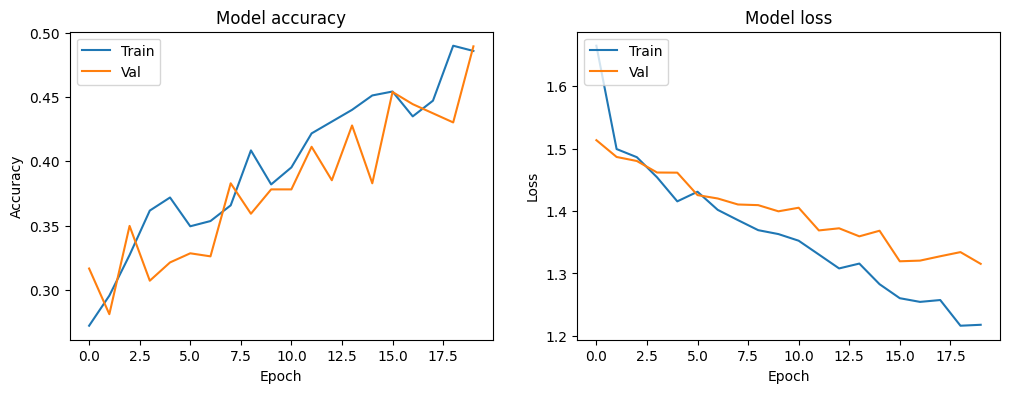

44/44 [==============================] - 28s 621ms/step - loss: 1.1961 - accuracy: 0.5466
Train accuracy: 0.5465529561042786
19/19 [==============================] - 13s 656ms/step - loss: 1.3764 - accuracy: 0.4238
Val accuracy: 0.42384105920791626


In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

print(f'Train accuracy: {model.evaluate(X_train, Y_train)[1]}')
print(f'Val accuracy: {model.evaluate(X_test, Y_test)[1]}')

19/19 [==============================] - 12s 596ms/step


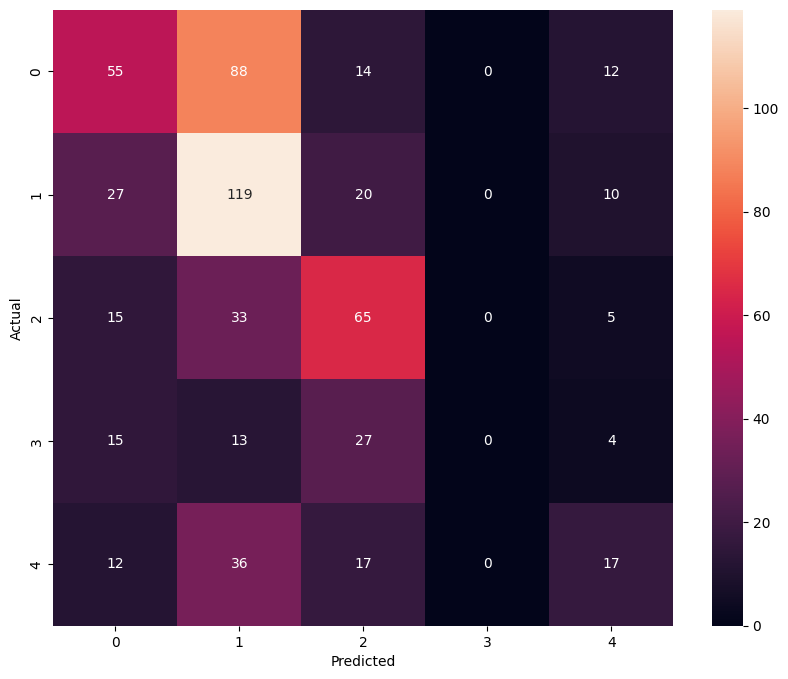

In [22]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [23]:
model.predict(np.array([X_test[2]]))

1/1 [==============================] - 0s 41ms/step


array([[0.06989428, 0.53163666, 0.25091553, 0.00588886, 0.14166477]],
      dtype=float32)

In [24]:
model.save('model.keras')


In [17]:
import tensorflow as tf
print(tf.__version__)


2.14.0
